## Introduction

This tutorial introduces spaciotemporal data analysis of Beijing City Service Call data, "*12345*".

Beijing 12345 Call is a non-emergency city services request and information inquiry service provided the City of Beijing. It is a Beijing version of 311 service call. 

The call dataset studied in this project is the 12345 data recorded from March 2017 to May 2018 in 2 large residential areas in the northern suburb of Beijing. The 2 large residential areas, Hui Long Guan and Tian Tong Yuan, consist of 7 neighborhoods and 132 communities.

The datasets used for the analysis are listed below,

| Dataset | Format | Content |
|---|---|---|
| **callvillage** | csv | Service type; Timestamp; Location |
| **village** | shp | Communities Polygons | 
| **town** | shp | Neighborhoods Polygons | 

## Setup

In [2]:
# import packages
library(sf)          
library(spData)
library(spDataLarge)
library(dplyr)
library(tidyverse)
library(stringr)
library(rgeos)
library(rgdal)
library(lubridate)
library(tmap)

In [3]:
# setup working directory
setwd("D:/Auguste/Projects/UrbanXYZ/working_data")

In [4]:
# read in call data with village ID as sf
callvillage <- read_sf('Join_Output.shp', quiet = FALSE)

# read in village boundaries 
village <- read_sf('huitian_village_190319.shp', quiet = FALSE)

# read in town boudaries
town <- read_sf('huitian_town_190319.shp', quiet = FALSE)

Reading layer `Join_Output' from data source `D:\Auguste\Projects\UrbanXYZ\working_data\Join_Output.shp' using driver `ESRI Shapefile'
Simple feature collection with 20109 features and 40 fields
geometry type:  POINT
dimension:      XY
bbox:           xmin: 116.26 ymin: 40.03734 xmax: 116.4391 ymax: 40.11632
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs
Reading layer `huitian_village_190319' from data source `D:\Auguste\Projects\UrbanXYZ\working_data\huitian_village_190319.shp' using driver `ESRI Shapefile'
Simple feature collection with 132 features and 16 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: 116.2514 ymin: 40.03632 xmax: 116.4398 ymax: 40.11748
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs
Reading layer `huitian_town_190319' from data source `D:\Auguste\Projects\UrbanXYZ\working_data\huitian_town_190319.shp' using driver `ESRI Shapefile'
Simple feature collection with 7 features and 16 field

In [5]:
# extract id, location, time, name columns from raw 12345 dataset
callvillage_clean <- callvillage %>%
  dplyr::select(FID_1, id_town,nm_town_2, id_ori, type_1, lng, lat, time, month, area)

callvillage_df <- callvillage_clean %>%
  st_drop_geometry() %>% # remove geom column for df wrangling
  mutate(
    time = ymd_hms(time), # convert string to lubridate POSIXt time object 
    date = date(time), # extract date without time 
    hour = hour(time), # hour in a day
    wday = wday(time, label = TRUE), # day in a week as ordered factor
    mday = mday(time) # day in a month
  )

## Exploratory Data Analysis

The basic time spans of this analysis are **Day**, **Week** and **Month**. Meanwhile, time units could be hours in a day (morning, afternoon, evening and night) or categories like weekdays and weeekend. The spatial levels are **communities** and **neighborhoods**.

Section 1 of the analysis explores the fluctuations of total number of calls in different time spans. Section 2 studies the spaciotemporal patterns of absolute amount and percentage of calls in different time spans at community level. Section 3 introduces types of service requests into the analysis by comparing their distributions in different time spans and spatial levels.

### Data Overview

In [8]:
# calls in months
callvillage_df %>%
  group_by(month) %>%
  summarise(call_num = n())

month,call_num
2017-03,1
2017-04,21
2017-05,1548
2017-06,1820
2017-07,1712
2017-08,1995
2017-09,1689
2017-10,1267
2017-11,2023
2017-12,1687


20109 calls were recorded from March 2017 to May 2018 in 410 days, 59 weeks and 15 months. Daily average is 49. Monthly average is 1340. 

March and April of 2017 have only 22 observations, which is significantly lower than the monthly average of 1340 service calls.  The following analysis ignore these 2 months as outliers for convenience. 

In [9]:
# March and April 2017 are negligible.
callvillage_month <- callvillage_df %>% 
  dplyr::filter(month != "2017-03" & month != "2017-04") # remove obs in March and April 2017

In [10]:
top_bottom <- callvillage_month %>%
  group_by(date) %>%
  summarise(call_num = n()) %>%
  arrange(desc(call_num))

top_bottom[c(1,394:396),]

date,call_num
2017-08-15,485
2018-02-15,2
2018-02-16,2
2018-02-19,2


The highest number of call in a day is August 15, 2017 with 485 records. The date will be studied as a random shock event later in the analysis. 

### Section 1: fluctuations in time spans

Day
-  fluctuates around daily average of 50
-  clear cyclical behavior (7-8 days)
-  3 peaks at June 2017, December 2017 and May 2018. 

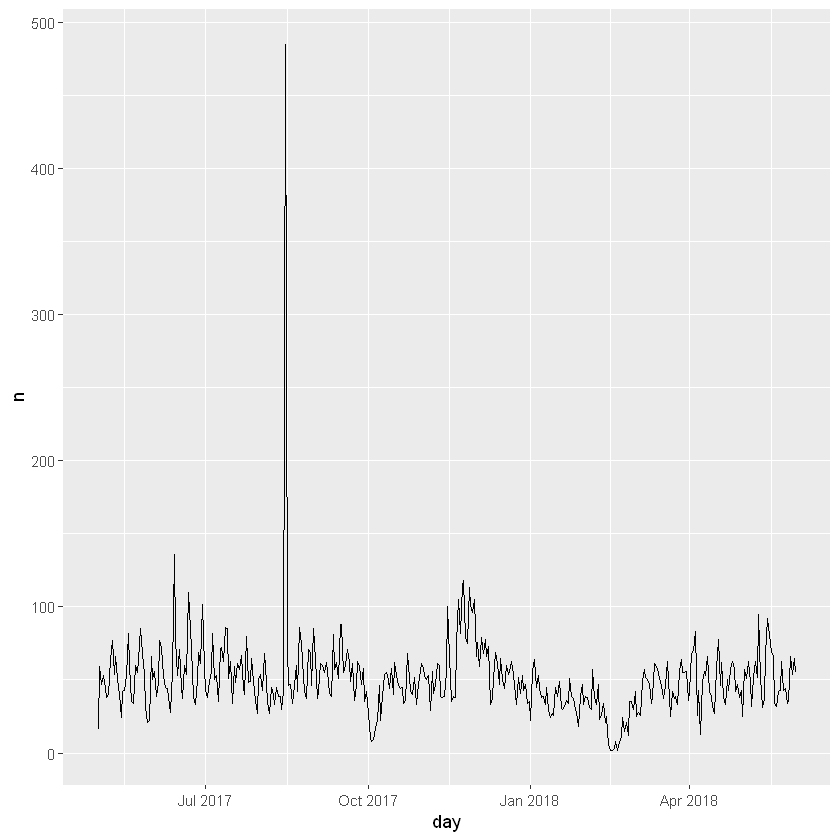

In [11]:
# Time Span: Day
callvillage_month %>%
  count(day = floor_date(time, "day")) %>%
  ggplot(aes(day, n)) + geom_line()

Week 
-  random walk like curve
-  peaks appeared close to daily fluctuation
-  August 2017 rises because of August $15^{th}$

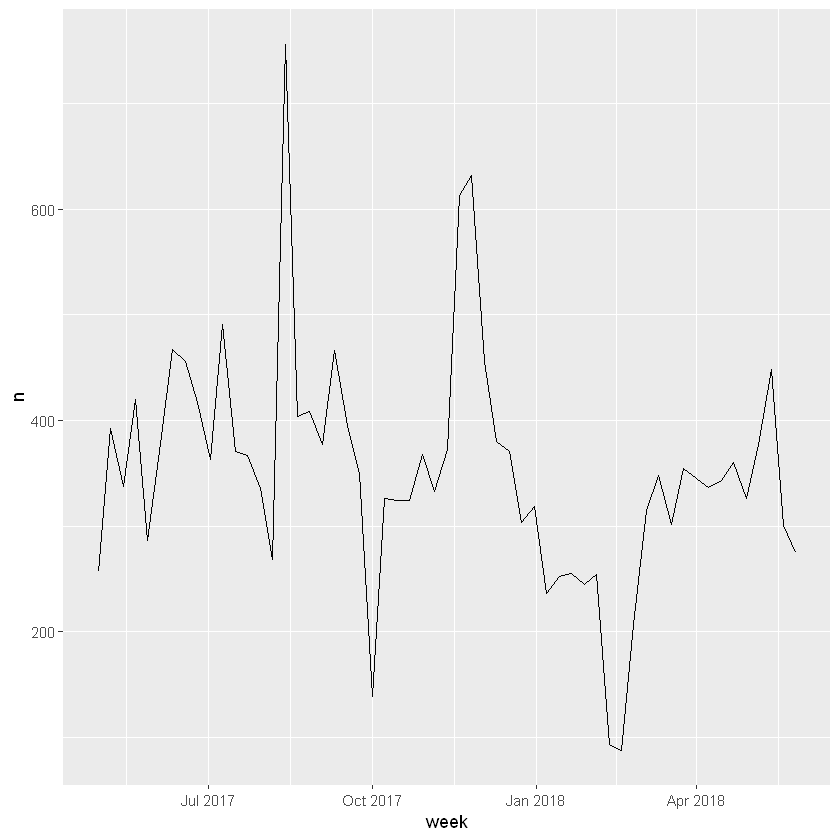

In [12]:
# Time Span: Week
callvillage_month %>%
  count(week = floor_date(time, "week")) %>%
  ggplot(aes(week, n)) + geom_line()

Month
-  A significant 6-month cycle

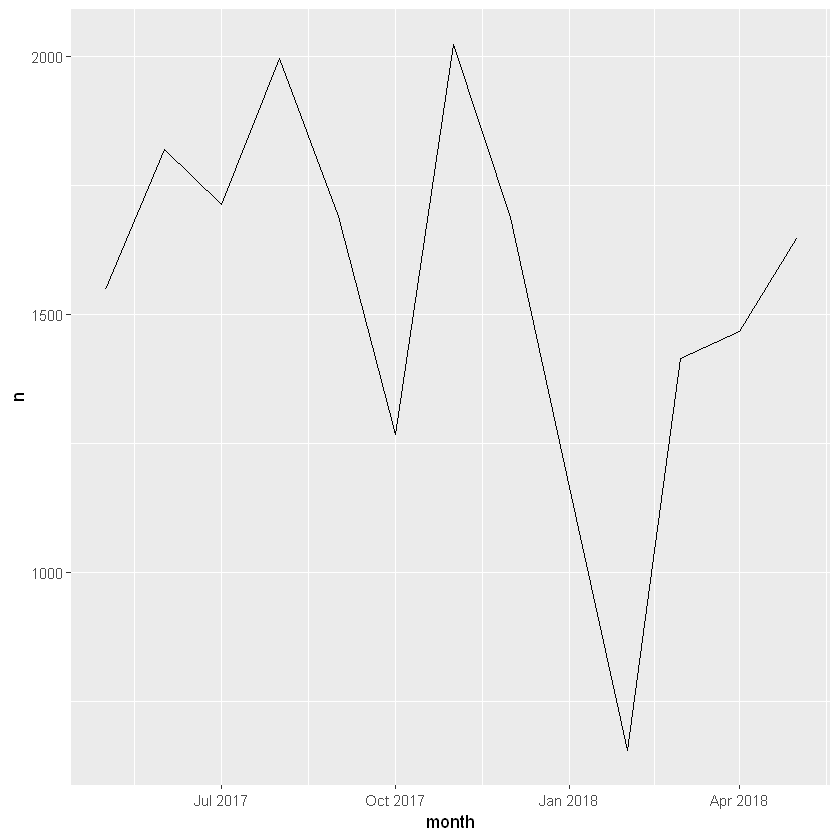

In [13]:
# Time Span: Month
callvillage_month %>%
  count(month = floor_date(time, "month")) %>%
  ggplot(aes(month, n)) + geom_line()